In [1]:
## plot boilerplate
%matplotlib inline
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
mpl.rcParams['figure.figsize'] = (12.0, 8.0)

## Scikit Learn "Working with Text" Example

In the [Scikit Learn](http://scikit-learn.org/stable/) documentation there is an [article](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html) providing details about using Scikit learn to perform classification on the newsgroup data set.  One example in the article that produces good results is as follows:

In [2]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']
twenty_train = fetch_20newsgroups(subset='train',
                                  categories=categories, shuffle=True, random_state=42)
twenty_test = fetch_20newsgroups(subset='test',
                                 categories=categories, shuffle=True, random_state=42)

text_clf = Pipeline([('vect', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                        alpha=1e-3, n_iter=5, random_state=42)),
])
_ = text_clf.fit(twenty_train.data, twenty_train.target)
predicted = text_clf.predict(twenty_test.data)
np.mean(predicted == twenty_test.target) 

0.9127829560585885

## Purpose of this Notebook

The rest of this notebook adapts the above example for the purposes of learning more about:

- sklearn pipelines
- custom sklearn TransformerMixins and BaseEstimators
- feeding sklearn pipelines from jsonl files

The classification problem being tested is slightly different than the one presented above. Namely:

- the data is in jsonl format.. that is line delimited json dictionaries with keys for content and label
- the classification problem is binary

---

## Preparing Test Data

To simulate jsonl file conditions:

- First we create a training data set by writing the newsgroup training data to a jsonl file, `test_data/train.jsonl`.  We will use `comp.graphics` as our target class so we will apply the label 1 if the newsgroup article is `comp.graphics` and 0 otherwise. 

- Next we write all categories from the newsgroup test data set line to a jsonl file, `test_data/test.jsonl` with the labels transformed to 0,1 as above.


In [3]:
## prepare the data for testing
import json

def ng_dirname(data_type):
    ''' simplify newsgroup jsonl acess, data_type = 'test' or 'train'
    '''
    return 'test_data/%s.jsonl' % data_type


with open(ng_dirname('train'), 'w') as train:
    for i in range(len(twenty_train.data)):
        json.dump({'label': int(twenty_train.target[i] == 3),
                   'name': twenty_train.target_names[twenty_train.target[i]],
                   'content': twenty_train.data[i]
              }, train)
        train.write('\n')
    
with open(ng_dirname('test'), 'w') as test:
    for i in range(len(twenty_test.data)):
        json.dump({'label': int(twenty_test.target[i] == 3),
                   'name': twenty_test.target_names[twenty_test.target[i]],
                   'content': twenty_test.data[i]
                  }, test)
        test.write('\n')

Now that we have `train_data.jsonl` and `test_data.jsonl` we can use a modified version of the above example to perform binary classification based off of the jsonl data:

In [8]:
import itertools as itt

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-3, n_iter=5, random_state=42)),
])

with open(ng_dirname('train'), 'r') as train, open(ng_dirname('test'), 'r') as test:
    x, y = itt.tee((json.loads(line) for line in train))
    u, v = itt.tee((json.loads(line) for line in test))
    predicted = text_clf.fit([i['content'] for i in x],
                             [j['label'] for j in y]).predict([i['content'] for i in u])
    print(np.mean(predicted == [j['label'] for j in v]))

0.936085219707


This also performs fairly well.  Switching from `hinge` loss to `perceptron` loss yields slightly better results:

In [9]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='perceptron', penalty='l2',
                                           alpha=1e-3, n_iter=5, random_state=42)),
])

with open(ng_dirname('train'), 'r') as train, open(ng_dirname('test'), 'r') as test:
    x, y = itt.tee((json.loads(line) for line in train))
    u, v = itt.tee((json.loads(line) for line in test))
    predicted = text_clf.fit([i['content'] for i in x],
                             [j['label'] for j in y]).predict([i['content'] for i in u])
    print(np.mean(predicted == [j['label'] for j in v]))

0.93741677763


## Calculate Similarity as BaseEstimator

---

In [13]:
from txtprocess import CosineSim

pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('cosine', CosineSim()) 
])

with open(ng_dirname('train'), 'r') as train, open(ng_dirname('test'), 'r') as test:
    x, y = itt.tee((json.loads(line) for line in train))
    u, v = itt.tee((json.loads(line) for line in test))
    d = pipe.fit([i['content'] for i in x],
                 [j['label'] for j in y]).predict([i['content'] for i in u])

## Examining the Results

Above we defined `d` which is a vector of similarity scores for each document.  It is in the same order as the original candidate json list. We can use this order to combine the scores with the labels and generate plots or tables.

---

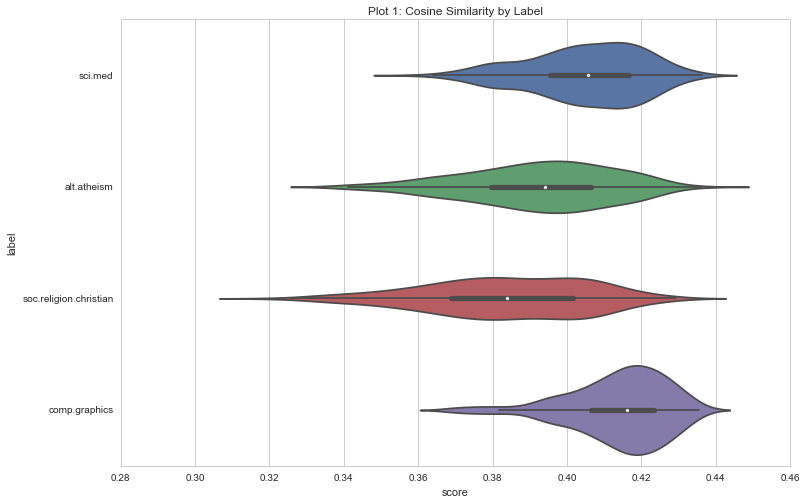

In [14]:
with open(ng_dirname('test'), 'r') as cf:
    result = [r for r in zip([json.loads(line)['name'] for line in cf], d)]
ax = plt.axes()
sns.violinplot(x="score", y="label",
              data=pd.DataFrame(result, columns=['label', 'score']),
              jitter=True)
ax.set_title('Plot 1: Cosine Similarity by Label')
plt.show()

From the above plot we can see that the newsgroup data is not highly seperable based on `cosine similarity`. However,  Comparing `comp.graphics` to the other labels in the `Plot 1` above we can see that we get a slight lift.

## Cosine Similarity as a Feature

We can use sklearn `FeatureUnion` to feed cosine similarity as a feature to the `SGDClassifier`.

In [20]:
from txtprocess import CosineSimTrans
from sklearn.pipeline import FeatureUnion

pipe = Pipeline([
        ('union', FeatureUnion(
            transformer_list=[
                ('trans1', Pipeline([
                    ('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                ])),
                ('trans2', Pipeline([
                    ('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('cosim', CosineSimTrans()),
                ])),
            ]
        )),
        ('estimators', Pipeline([
                    ('clf', SGDClassifier(loss='perceptron', penalty='l2',
                                          alpha=1e-3, n_iter=5, random_state=42))
                    ])
        )
])

In [21]:
with open(ng_dirname('train'), 'r') as train, open(ng_dirname('test'), 'r') as test:
    x, y = itt.tee((json.loads(line) for line in train))
    u, v = itt.tee((json.loads(line) for line in test))
    predicted = pipe.fit([i['content'] for i in x],
                 [j['label'] for j in y]).predict([i['content'] for i in u])
    print(np.mean(predicted == [j['label'] for j in v]))

0.950732356858


And we have improved our classification's performance on the test data set.